Procedure Outline:

1. Collect each set of books and merge all the books together.
2. Get rid of all the columns except "Review Text" and "Review Score".
3. Clean up "Review Text" column (text only) without modifying order/number of rows.
4. Check to see if there is a 1:1 relationship between len("Review Text") and len("Review Score").
5. Call function to build maxtrix; will have in the end: X, y and vectorizer.
6. Convert "Review Score" to multiple classes: "Negative", "Neutral" and "Positive" classes.
7. Now with X and y, able to run these values through M.L. Classifiers: M.N. Naive Bayes, Decision Tree and Random Forest.
8. Each model's performance metrics analyzed in order to determine best classifier amongst three options. 

The purpose of this notebook is to use Machine Learning (M.L.) in order to classify
Amazon book reviews into three different sentiments: negative, neutral and positive.

In [2]:
%matplotlib inline
import time
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from six.moves import range

from pandas import Series, DataFrame
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
#From each book that is read in create a pandas data frame for each one

def all_books(books):
    result = []
    
    i = 0  
    while i < len(books):
        more_elements = pd.read_csv(books[i], sep='\t', 
                  names = ["Review Score", "Tail of Review URL", "Review Title", "Review Text"])  
        result.append(more_elements) 
        i += 1 
        
    return(result)

In [4]:
#Read in all book reviews

books = ["Andy-Weir-The-Martian.csv", "Donna-Tartt-The-Goldfinch.csv", 
         "EL-James-Fifty-Shades-of-Grey.csv", "Fillian_Flynn-Gone_Girl.csv", 
         "John-Green-The-Fault-in-our-Stars.csv", "Laura-Hillenbrand-Unbroken.csv", 
         "Paula_Hawkins-The-Girl-On-The-Train.csv", "Suzanne-Collins-The-Hunger-Games.csv"]

all_reviews = []
all_reviews = all_books(books)

In [5]:
#Combining all data frames to work off of one big data frame

#Concat function used here
comb_DFs = pd.concat([all_reviews[0], all_reviews[1], all_reviews[2], all_reviews[3], all_reviews[4], all_reviews[5], all_reviews[6], all_reviews[7]], ignore_index=True)

In [6]:
#To verify that combining data frames worked: Checking that number of reviews in new big data frame matches sum of reviews from all books

len(comb_DFs)

243269

In [7]:
#Took a look at the first entries of the big data frame

comb_DFs.head(10)

,Review Score,Tail of Review URL,Review Title,Review Text
0,4.0,/gp/customer-reviews/RKMO449VT48H3?ASIN=149159...,4.7573214851 Stars,"<span class=""a-size-base review-text"">I'm a ha..."
1,3.0,/gp/customer-reviews/R3RDNZNCOMRN0K?ASIN=14915...,Who needs nail clippers?,"<span class=""a-size-base review-text"">""I'm str..."
2,4.0,/gp/customer-reviews/R1TC15NPCF9GMW?ASIN=14915...,Abandoned on Mars,"<span class=""a-size-base review-text"">A futuri..."
3,5.0,/gp/customer-reviews/RT3R8XN5KZZGW?ASIN=149159...,Excellent Story,"<span class=""a-size-base review-text"">Follow t..."
4,5.0,/gp/customer-reviews/R32NNLGY7QGRVJ?ASIN=14915...,"Inventive, humorous, tedious","<span class=""a-size-base review-text"">This is ..."
5,5.0,/gp/customer-reviews/R14NNZV8RFYM5K?ASIN=14915...,Cool science and tech...but no life on Mars,"<span class=""a-size-base review-text"">The Mart..."
6,3.0,/gp/customer-reviews/R7IJIAHW6TK62?ASIN=149159...,Hard Sci-Fi For The Win!,"<span class=""a-size-base review-text"">I can't ..."
7,3.0,/gp/customer-reviews/R62IPW4T33YZ4?ASIN=149159...,Wonderful,"<span class=""a-size-base review-text"">A fascin..."
8,5.0,/gp/customer-reviews/R3GFO6M9HJB5KZ?ASIN=14915...,"Science is great, writing is fair.","<span class=""a-size-base review-text"">Sorry......"
9,5.0,/gp/customer-reviews/R1RZMRWYGW49DM?ASIN=14915...,Best physics class ever!,"<span class=""a-size-base review-text"">I just f..."


In [8]:
#Separating out the reviews column from the big data frame.
#Also verifying that it has the same amount of rows as in the big data frame

reviews = comb_DFs['Review Text']
len(reviews)

243269

In [9]:
##Separating out the scores column from the big data frame.
#Also verifying that it has the same amount of rows as in the big data frame

scores = comb_DFs['Review Score']
len(scores)

243269

In [10]:
#Taking a look at what a raw review looks like
reviews[243268]

'<span class="a-size-base review-text">If I could rate this book a zero I would... The book was to all over the place.. Ive herd many good things about this book aand the others...Woorst book I hae EVER reead  Dont read it!!!!!!!!</span>'

In [11]:
#Cleaning up the reviews so that what is remaining is pure text

import re
import string


def cleaned_reviews(reviews):
    result2 = []
    for r in reviews:
        r = r.lstrip('<span class="a-size-base review-text">')
        r = r.rstrip('</span>')
        
        r.replace('<br/><br/>', ' ')
        r.replace('<br/>', ' ')
        r.replace('\\','') 
           
        table = string.maketrans("","") 
        r = r.translate(table, string.punctuation)
        result2.append(r)

    return result2

In [12]:
#Calling function to clean up all reviews

r_all = []
r_all = cleaned_reviews(reviews)

In [13]:
#Checking cleaned_reviews function 
#Verifying that text is clean. 

r_all[243268]

'If I could rate this book a zero I would The book was to all over the place Ive herd many good things about this book aand the othersWoorst book I hae EVER reead  Dont read it'

In [14]:
#Vectorizing reviews and scores (along with changing scores into three different sentiment classes) 

#Thank you to Harvard CS109 course and my mentor, AJ, for help with this portion.

def buildMatrixAndVector(r_all, scores, vectorizer=None):
    
    # initialize vectorizer if none is provided
    if vectorizer is None:
        vectorizer = CountVectorizer()
    
    # create X using the vectorizer on the reviews
    X = vectorizer.fit_transform(r_all)
    
    # check out the type and shape of X
    print("... in buildMatrixAndVector: ")
    print("... type of X as returned by vectorizer.fit_transform(reviews): " + str(type(X)))
    print("... shape of X as returned by vectorizer.fit_transform(reviews): " + str(X.shape))
    
    # transform X to compressed Sparse Column format (CSC)
    X = X.tocsc()
    
    # check out the type and shape of X after the transformation
    print("... in buildMatrixAndVector: ")
    print("... type of X as transformed by tocsc(): " + str(type(X)))
    print("... shape of X as as transformed by tocsc(): " + str(X.shape))
    
    # now get y from labels
    # in this case this is a multi-class problem, so we 
    # transform {1, 2} to 1; {3} to 2; and {4, 5} to 3
    # for sentiment classification - 1 = negative, 2 = neutral, 3 = positive
    y = scores.apply(lambda x: 1 if x in range(1,3) 
                          else 3 if x in range(4,6) 
                          else 2)
    
    # check out the type and shape of y
    print("... in buildMatrixAndVector: ")
    print("... type of y: " + str(type(y)))
    print("... length of y: " + str(y.shape))
    
    # return what we have built, including the vectorizer object
    return X, y, vectorizer

In [15]:
#Calling function using all of the cleaned up reviews and its paired scores

X, y, vectorizer = buildMatrixAndVector(r_all, scores)

... in buildMatrixAndVector: 
... type of X as returned by vectorizer.fit_transform(reviews): <class 'scipy.sparse.csr.csr_matrix'>
... shape of X as returned by vectorizer.fit_transform(reviews): (243269, 153408)
... in buildMatrixAndVector: 
... type of X as transformed by tocsc(): <class 'scipy.sparse.csc.csc_matrix'>
... shape of X as as transformed by tocsc(): (243269, 153408)
... in buildMatrixAndVector: 
... type of y: <class 'pandas.core.series.Series'>
... length of y: (243269,)


In [16]:
#Using MultiNomial Naive Bayes Classifier to predict reviews' sentiments

from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y)

start_time = time.clock() 
clf = MultinomialNB().fit(xtrain, ytrain)
proc_time = time.clock() - start_time

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print ("\nProcessing time for MultinomialNB: " + str(proc_time) + " secs")

/Users/mindyng/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy on training data: 0.75
Accuracy on test data:     0.72

Processing time for MultinomialNB: 0.14372 secs


In [17]:
#Training and Testing Accuracies are pretty close. 
#This means that this model did not overfit on its Training data.
#Therefore, it was able to generalize well enough in order to predict 
#unseen test data's classes well.

In [18]:
#Classification Report for M.N. Naive Bayes Classifier

# classification_report() function displays the 
# precision, recall, f1-score and support for each class.

from sklearn.metrics import classification_report

model = MultinomialNB()
model.fit(xtrain, ytrain)
predicted = model.predict(xtest)
report = classification_report(ytest, predicted)
print(report)

             precision    recall  f1-score   support

          1       0.45      0.26      0.33      9628
          2       0.19      0.02      0.04      6879
          3       0.76      0.93      0.84     44311

avg / total       0.65      0.72      0.67     60818



In [19]:
# Precision:  ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is the accuracy of the positive predictions.
# The best value is 1 and the worst value is 0.

In [20]:
# Recall: ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
# The best value is 1 and the worst value is 0.

In [21]:
# F-1 Score: weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
# F1 = 2 * (precision * recall) / (precision + recall)
# In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.

In [22]:
# Based on the classification report, prediction for category '2' was the worst,
# category '1' was a little better. And prediction for category '3' was the best. 

# This makes sense since the training data is highly skewed towards
# category 3. 

# Given the low Precision, Recall and F1-score values for categories
# '1' and '2', there is room for improving the model.

In [23]:
#Trying to improve classifier performance by tuning MultiNomial Naive Bayes Classifier's alpha parameter 

from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split


alphas = [.1, 1, 5, 10, 50]
    
start_time = time.clock()
for i in alphas:
    
    xtrain, xtest, ytrain, ytest = train_test_split(X, y)
    clf = MultinomialNB(i).fit(xtrain, ytrain)

    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)

    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
proc_time = time.clock() - start_time
print ("\nProcessing time for 5 runs of MultinomialNB: " + str(proc_time) + " secs")

Accuracy on training data: 0.76
Accuracy on test data:     0.68
Accuracy on training data: 0.75
Accuracy on test data:     0.72
Accuracy on training data: 0.74
Accuracy on test data:     0.73
Accuracy on training data: 0.73
Accuracy on test data:     0.73
Accuracy on training data: 0.73
Accuracy on test data:     0.73

Processing time for 5 runs of MultinomialNB: 4.875137 secs


In [24]:
# Choosing different alpha values did improve performance by huge amount. 
# Durng this run, alpha = 0.1 had the highest values. Also, training and test data were
# very close, which means that training data was very good at setting up
# model to use on new test data.

In [25]:
# Due to the first alpha value = 0.1 giving the highest accuracy percentages, 
# this value is used to evaluate classification model's performance with Confusion Matrix. 

In [26]:
#Isolating Training and Test Accuracy results from hyperparameter, alpha, set at 0.1

from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y)
clf = MultinomialNB(0.1).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.76
Accuracy on test data:     0.67


In [27]:
#Other Performance metric on Multiclass Classifier - MultiNomial Naive Bayes Classifier

##Confusion Matrix

from sklearn.metrics import confusion_matrix

model = MultinomialNB(0.1)
model.fit(xtrain, ytrain)
predicted = model.predict(xtest)
matrix = confusion_matrix(ytest, predicted)
print(matrix)

# Each column represents instances of PREDICTED class
# Each row represents instances in ACTUAL class

[[ 3202   743  5673]
 [  942   844  5213]
 [ 4184  3173 36844]]


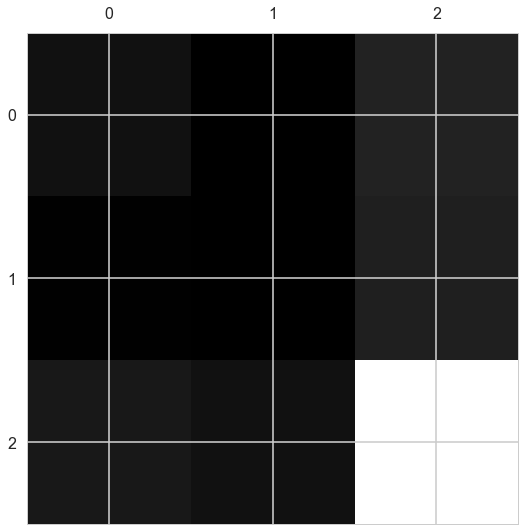

In [28]:
##Image representation of confusion matrix.

plt.matshow(matrix, cmap=plt.cm.gray)
plt.show()

In [29]:
# The majority of the predictions do not fall on the diagonal of the line
# of the matrix (which are the correct predictions).

# The only value that is huge is the bottom right, which corresponds to 
# positive ratings. This makes sense since this category had the highest
# proportion of traning data.

# Let's try another classification model in order to improve model performance. 

In [30]:
# Decision Tree model:

from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()

start_time = time.clock() 
tree_clf.fit(xtrain,ytrain)
proc_time = time.clock() - start_time

training_accuracy2 = tree_clf.score(xtrain, ytrain)
test_accuracy2 = tree_clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy2)
print "Accuracy on test data:     %0.2f" % (test_accuracy2)
print ("\nProcessing time for DecisionTreeClassifier: " + str(proc_time) + " secs")

Accuracy on training data: 0.99
Accuracy on test data:     0.63

Processing time for DecisionTreeClassifier: 883.85925 secs


In [31]:
#Classification Report for Decision Tree Classifier

# classification_report() function displays the 
# precision, recall, f1-score and support for each class.

from sklearn.metrics import classification_report

model = DecisionTreeClassifier()
model.fit(xtrain, ytrain)
predicted = model.predict(xtest)
report = classification_report(ytest, predicted)
print(report)

             precision    recall  f1-score   support

          1       0.26      0.22      0.24      9618
          2       0.13      0.10      0.11      6999
          3       0.75      0.80      0.77     44201

avg / total       0.60      0.63      0.61     60818



In [32]:
#Other Performance metric on Multiclass Classifier - Decision Tree Classifier

##Confusion Matrix

from sklearn.metrics import confusion_matrix

model = DecisionTreeClassifier()
model.fit(xtrain, ytrain)
predicted = model.predict(xtest)
matrix = confusion_matrix(ytest, predicted)
print(matrix)

# Each column represents instances of PREDICTED class
# Each row represents instances in ACTUAL class

[[ 2116   836  6666]
 [  960   720  5319]
 [ 5198  3900 35103]]


In [33]:
# Random Forest model:

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()

start_time = time.clock()
forest_clf.fit(xtrain, ytrain)
proc_time = time.clock() - start_time

training_accuracy3 = forest_clf.score(xtrain, ytrain)
test_accuracy3 = forest_clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy3)
print "Accuracy on test data:     %0.2f" % (test_accuracy3)
print ("\nProcessing time for RandomForestClassifier: " + str(proc_time) + " secs")

Accuracy on training data: 0.97
Accuracy on test data:     0.72

Processing time for RandomForestClassifier: 668.978142 secs


In [34]:
#Classification Report for Random Forest Classifier

# classification_report() function displays the 
# precision, recall, f1-score and support for each class.

from sklearn.metrics import classification_report

model = RandomForestClassifier()
model.fit(xtrain, ytrain)
predicted = model.predict(xtest)
report = classification_report(ytest, predicted)
print(report)

             precision    recall  f1-score   support

          1       0.39      0.10      0.16      9618
          2       0.14      0.01      0.02      6999
          3       0.74      0.96      0.83     44201

avg / total       0.61      0.72      0.63     60818



In [35]:
#Other Performance metrics on Multiclass Classifier - Random Forest Classifier

##Confusion Matrix

from sklearn.metrics import confusion_matrix

model = RandomForestClassifier()
model.fit(xtrain, ytrain)
predicted = model.predict(xtest)
matrix = confusion_matrix(ytest, predicted)
print(matrix)

# Each column represents instances of PREDICTED class
# Each row represents instances in ACTUAL class

[[  971   106  8541]
 [  236    84  6679]
 [ 1240   405 42556]]


In [36]:
#Model Performance Accuracy

In [38]:
import plotly.plotly as py
import plotly.figure_factory as ff

data_matrix = [['Model Performance Measurement', 'M.N. Naive Bayes', 'Decision Tree', 'Random Forest'],
               ['Precision (Average)', 0.65, 0.6, 0.61], 
               ['Recall (Average)', 0.72,  0.63, .72],
               ['Training Accuracy', .76, .99, .97],
               ['Test Accuracy', .67, .63, .72]]

table = ff.create_table(data_matrix)
py.iplot(table, filename='simple_table')

Conclusion

Precision: This tells us how exact the classifier is. 
The higher the number, the less false positives there are.

Recall: This tells us how complete/sensitive the classifier is. 
The higher the number, the less false negatives there are. 

Accuracy: Percentage of correct predictions.

Given, the model performance measurements with results closest to 1.0 will be the best predicting model. 
And the winner is Random Forest model since it has overall high performance measurements across the board.